## **TÓPICOS AVANÇADOS EM APRENDIZAGEM DE MÁQUINA - CK0255**

#### **Professores:**
##### João Paulo P. Gomes / César Lincoln C. Matos

#### **Discente:**
##### Matheus do Vale Almeida - 473219

---


In [2]:
# Bibliotecas
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal

#### Importa Data 01

In [3]:
# Import data
clustering_data = np.genfromtxt('./clustering_data.csv', delimiter=',')

In [9]:
print(f"> Dataset shape: {clustering_data.shape}")

> Dataset shape: (100, 2)


## **Trabalho 03**

### **Parte 1**
Implemente a solução MAP para o GMM (Guassian Mixture Model) utilizando os dados disponíveis em **clustering_data.csv**.
* Realize testes do seu método vairando o número de componentes do GMM (use 2, 4, 6, 8 e 10)
* Apresente uma figura com a distribuição a posteriori e os dados usados para treinamento.

In [261]:
def log_likelihood(X, K, pi, mi, Sigma):
    log_likelihood = 0
    for i in range(X.shape[0]):
        likelihood_i = 0
        for k in range(K):
            likelihood_i += pi[k] * multivariate_normal.pdf(X[i], mean=mi[k], cov=Sigma[k])
        log_likelihood += np.log(likelihood_i)
    
    return log_likelihood

In [533]:
def gmm_MAP(K, dataset):
    prev_log_likelihood = -np.inf

    N = dataset.shape[0]
    D = dataset.shape[1]

    # Escolha K, αk ,μ0, κ0, ν0, S0, π(0)k, μ(0)k, Σ(0)k, ∀k.
    alpha = np.ones(K)
    mi0 = np.mean(dataset, axis=0)
    k0 = 0.01
    v0 = D + 2
    s0 = 1 / (K**(2/D))
    pi_k = np.ones(K) / K
    mi_k = np.random.rand(K, D)
    Sigma = np.tile(np.eye(D), (K, 1, 1))
    
    # Faça t = 1 e repita até convergir:
    for t in range(100):
        # Passo E: ===========================================================================
        rik = np.empty((K, N))
        for k in range(K):
            rik[k] = pi_k[k] * multivariate_normal(mean=mi_k[k], cov=Sigma[k]).pdf(dataset)
        rik /= rik.sum(axis=0)

        # Passo M: ===========================================================================
        for k in range(K):
            pi_k[k] = alpha[k] - 1 + np.sum(rik[k]) / (N - K) + np.sum(alpha)
        
            xk_ = np.sum(rik[k].reshape((-1, 1)) * dataset, axis=0) / np.sum(rik[k])
            
            mi_k[k] = (k0 * mi0 + xk_ * np.sum(rik[k])) / (k0 + np.sum(rik[k]))
            
            term1 = s0 + np.sum(rik[k] * (dataset - xk_).T @ (dataset - xk_), axis=0)
            term2 = ((k0 * np.sum(rik[k])) / (k0 + np.sum(rik[k]))) * (xk_ - mi0) @ (xk_ - mi0).T
            Sigma[k] = (term1 + term2) / (v0 + D + 2 + np.sum(rik[k]))
        
        current_log_likelihood = log_likelihood(dataset, K, pi_k, mi_k, Sigma)
        likelihood_difference = current_log_likelihood - prev_log_likelihood
        prev_log_likelihood = current_log_likelihood

        # Verifica a convergência
        if abs(likelihood_difference) < 1e-4:
            print(f'> K = {K} | Convergiu após {t+1} iterações.')
            break

    return pi_k, mi_k, Sigma
    

In [534]:
KS = [2, 4, 6, 8, 10]
pi = []
mi = []
sigma = []

for k in KS:
    pi_temp, mi_temp, sigma_temp = gmm_MAP(k, clustering_data)
    pi.append(pi_temp)
    mi.append(mi_temp)
    sigma.append(sigma_temp)

> K = 2 | Convergiu após 14 iterações.


ValueError: The input matrix must be symmetric positive semidefinite.

In [476]:
def gmm_prob(data, pi_array, mi_array, cov_array):
    K = pi_array.shape[0]
    probs = np.empty(K)
    
    for k in range(K):
        probs[k] = pi_array[k] * multivariate_normal(mi_array[k], cov_array[k]).pdf(data)
    
    return np.sum(probs, axis=0)

In [477]:
x1, x2 = np.mgrid[
                slice(np.min(clustering_data[:,0]) - 1, np.max(clustering_data[:, 0]) + 1, 0.1),
                slice(np.min(clustering_data[:,1]) - 1, np.max(clustering_data[:, 1]) + 1, 0.1)
                ]
x_plot = np.dstack((x1, x2))
values = [np.apply_along_axis(func1d = gmm_prob, arr = x_plot, axis = 2, pi_array = pi[k], mi_array = mi[k], cov_array = sigma[k]) for k in range(len(KS))]

IndexError: list index out of range

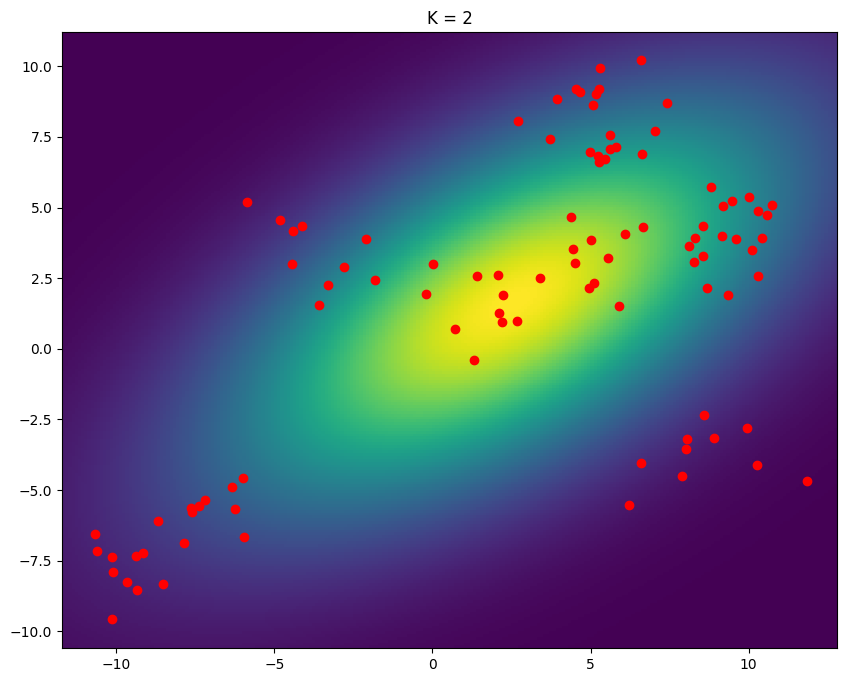

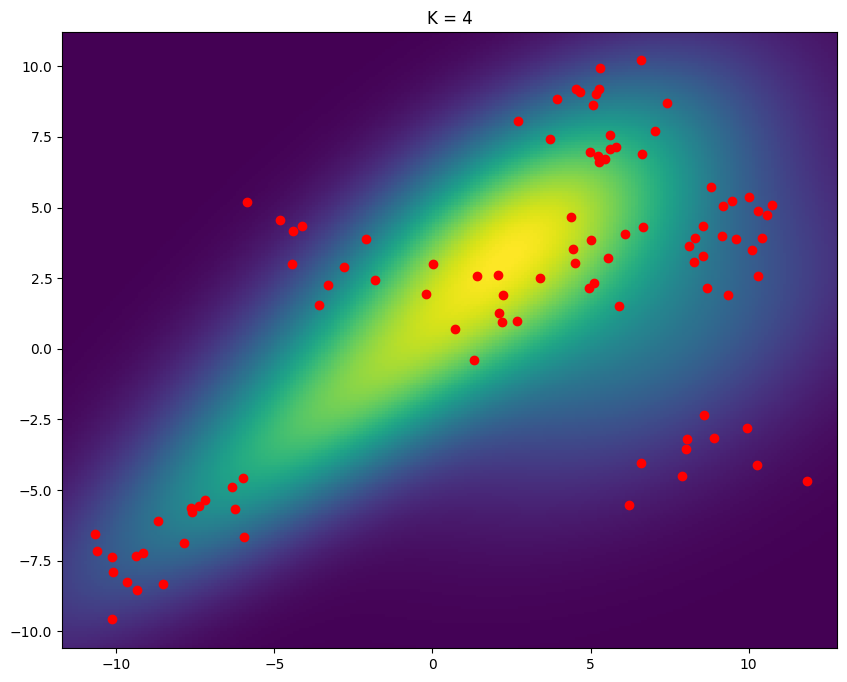

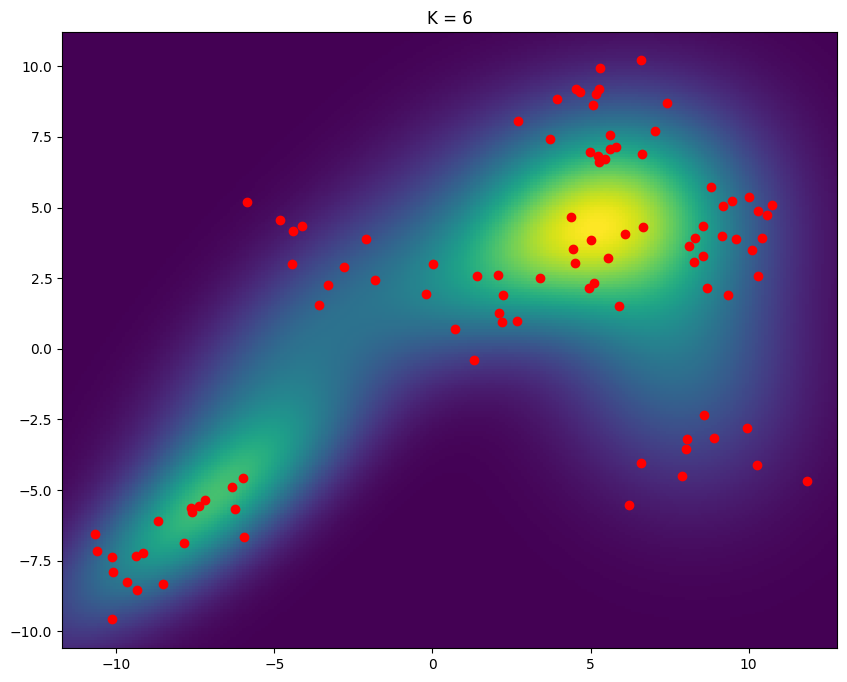

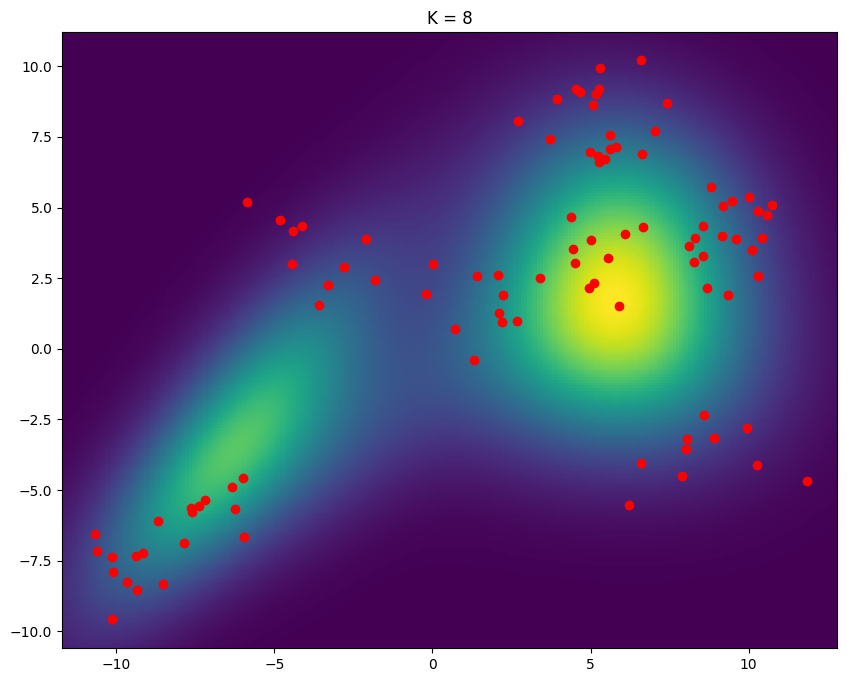

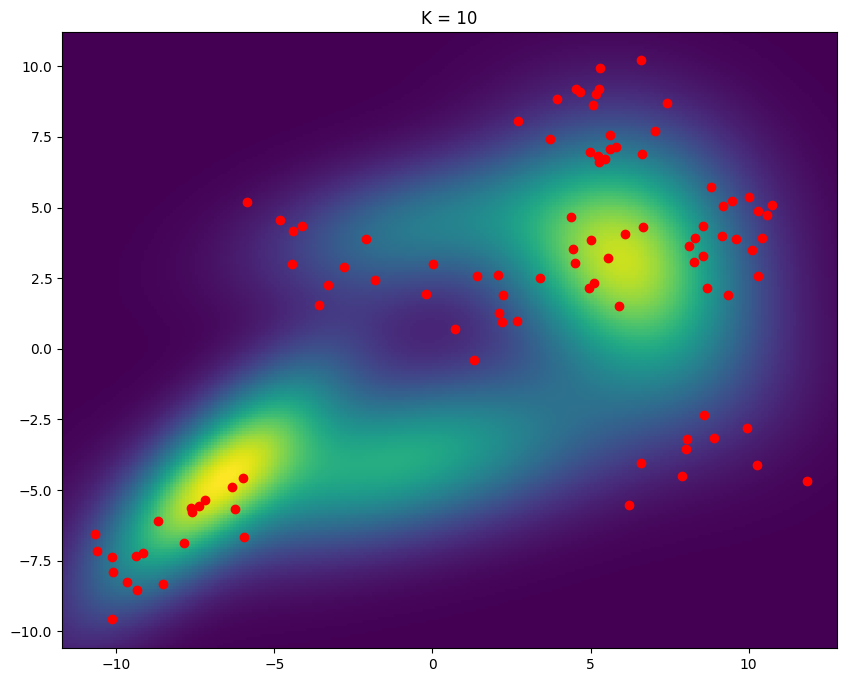

In [487]:
for k in range(len(KS)):
    plt.figure(figsize=(10,8))
    back = plt.pcolormesh(x1, x2, values[k], cmap = 'viridis')
    scatter = plt.scatter(clustering_data[:, 0], clustering_data[:, 1], color = 'red')
    plt.title(f"K = {KS[k]}")
    plt.show()